# Structured Streaming编程

## 总览

Structured Streaming是基于Spark SQL引擎构建的可扩展且容错的流处理引擎。您可以像对静态数据进行批处理计算一样来表示流计算。当流数据持续到达时，Spark SQL引擎将负责递增地，连续地运行它并更新最终结果。您可以在Scala，Java，Python或R中使用[Dataset/DataFrame API](https://spark.apache.org/docs/latest/sql-programming-guide.html)来表示流聚合，事件时间窗口，流-批Join等。计算在同一优化的Spark SQL引擎上执行。最后，系统通过检查点和预写日志来确保端到端的Exactly-Once的容错语义。简而言之，Structured Streaming提供了快速，可扩展，容错，端到端，Exactly-Once容错语义的流处理，而且用户无需推理流。

在内部，默认情况下，Structured Streaming查询是使用“**微批处理(Micro-batch Processing)**”引擎处理的，该引擎将数据流作为一系列小批处理作业进行处理，从而实现了低至100毫秒的端到端延迟以及Exactly-Once的语义保证。但是，从Spark 2.3开始，我们引入了一种称为“**连续处理(Continuous Processing)**”的新低延迟处理模式，该模式可以保证1毫秒的端到端延迟和At-Least-Once的容错语义。在不更改查询中的Dataset/DataFrame操作的情况下，您将能够根据应用程序需求选择模式。

在本指南中，我们将带您逐步了解编程模型和API。我们将主要使用默认的微批处理模型来解释这些概念，然后再讨论连续处理模型。首先，让我们从Structured Streaming查询的简单示例——字计数器开始。


## 快速范例
假设您要维护从侦听TCP套接字的数据服务器接收到的文本数据的字计数器。让我们看看如何使用Structured Streaming来表达这一点。您可以在[Scala](https://github.com/apache/spark/blob/v3.0.1/examples/src/main/scala/org/apache/spark/examples/sql/streaming/StructuredNetworkWordCount.scala)/[Java](https://github.com/apache/spark/blob/v3.0.1/examples/src/main/java/org/apache/spark/examples/sql/streaming/JavaStructuredNetworkWordCount.java)/[Python](https://github.com/apache/spark/blob/v3.0.1/examples/src/main/python/sql/streaming/structured_network_wordcount.py)/[R](https://github.com/apache/spark/blob/v3.0.1/examples/src/main/r/streaming/structured_network_wordcount.R)中看到完整的代码。如果下载了Spark，则可以直接运行该示例。无论如何，让我们逐步介绍示例并了解其工作原理。首先，我们必须导入必要的类并创建本地SparkSession，这是与Spark相关的所有功能的起点。

```python
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split

spark = SparkSession \
    .builder \
    .appName("StructuredNetworkWordCount") \
    .getOrCreate()
```

接下来，让我们创建一个流式DataFrame，该DataFrame表示从在localhost:9999上侦听的服务器接收的文本数据，并对DataFrame进行转换以计算字数。

```python
# Create DataFrame representing the stream of input lines from connection to localhost:9999
lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

# Split the lines into words
words = lines.select(
   explode(
       split(lines.value, " ")
   ).alias("word")
)

# Generate running word count
wordCounts = words.groupBy("word").count()
```

此DataFrame`lines`表示一个包含流文本数据的无界表。该表包含一列名为“value”的字符串，流文本数据中的每一行都成为表中的一行。请注意，由于我们正在设置转换，并且尚未开始转换，因此它目前未接收任何数据。接下来，我们使用了两个内置的SQL函数——split和explode，将每一行拆分为多行，每行各有一个单词。另外，我们使用函数alias将新列命名为“word”。最后，我们通过对DataSet中的唯一值进行分组并对其进行计数来定义DataFrame`wordCounts`。请注意，这是一个流式DataFrame，它表示流的运行字计数。

现在，我们对流数据进行了查询。剩下的就是实际开始接收数据并计算计数了。为此，我们将模式设置为在每次更新计数时将完整的计数集（由`outputMode("complete")`指定）打印到控制台。然后使用开始流计算`start()`。

```python
 # Start running the query that prints the running counts to the console
query = wordCounts \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

query.awaitTermination()
```

执行此代码后，流计算将在后台开始。该query对象是该活动流查询的句柄，我们已决定等待查询终止，awaitTermination()以防止查询处于活动状态时退出该过程。

要实际执行此示例代码，可以在自己的Spark应用程序中编译代码，也可以在下载Spark之后直接运行示例。我们正在展示后者。您首先需要通过使用以下命令将Netcat（在大多数类Unix系统中找到的一个小实用程序）作为数据服务器运行
```bash
nc -lk 9999
```

然后，在另一个终端中，您可以通过使用
```bash
./bin/spark-submit examples/src/main/python/sql/streaming/structured_network_wordcount.py localhost 9999
```

然后，将对运行netcat服务器的终端中键入的任何行进行计数并每秒打印一次。它将类似于以下内容。

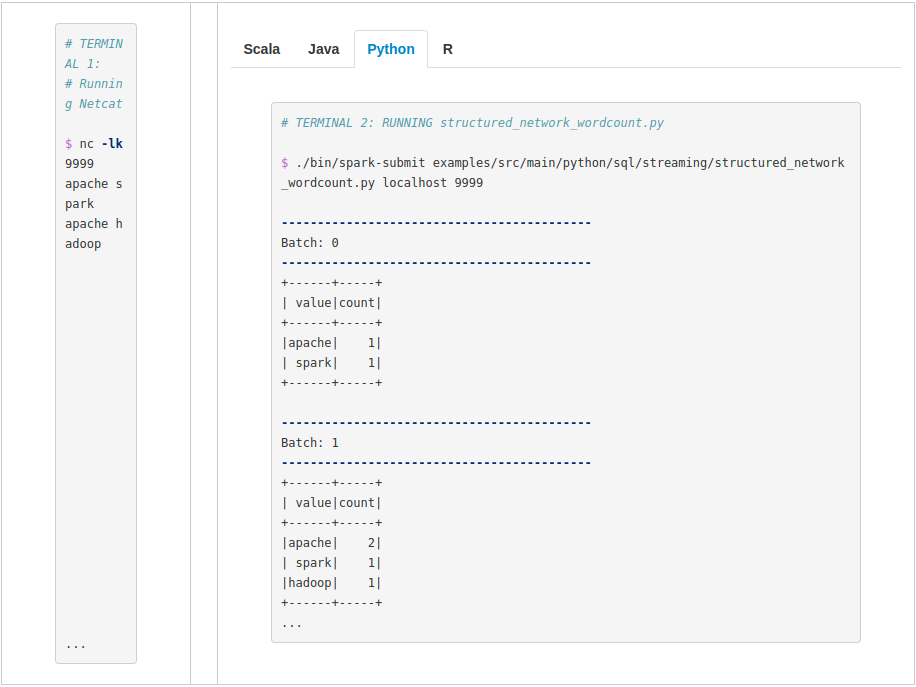

## 程式设计模型
Structured Streaming传输中的关键思想是将实时数据流视为被连续添加的表。这产生了一个新的流处理模型，该模型与批处理模型非常相似。您将像在静态表上一样将流计算表示为类似于批处理的标准查询，Spark在无界输入表上将其作为增量查询运行。让我们更详细地了解此模型。

### 基本概念

将输入数据流视为“输入表”。流上到达的每个数据项都像是将新行附加到输入表中。

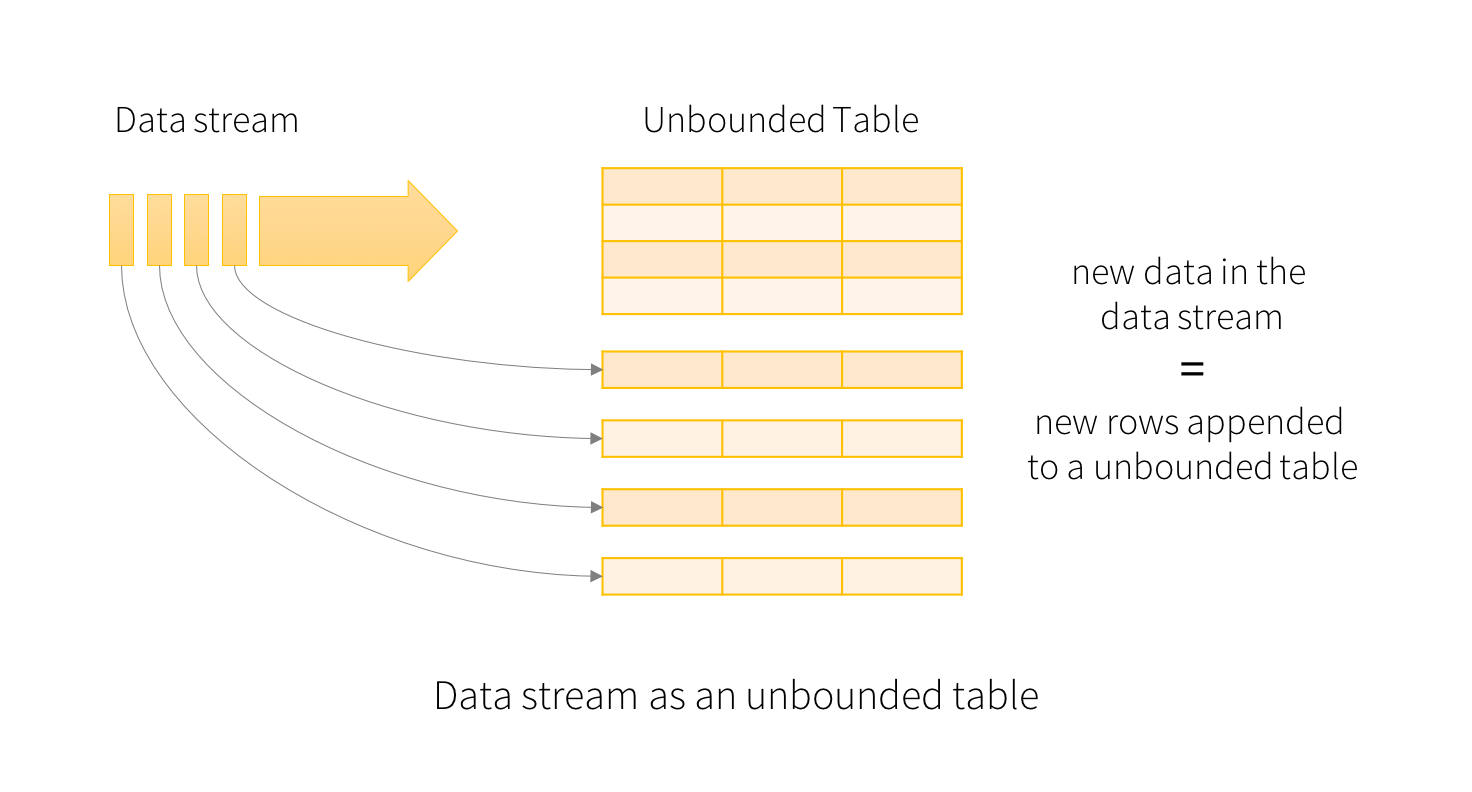
对输入的查询将生成“结果表”。在每个触发间隔（例如，每1秒钟），新行将附加到输入表中，并最终更新结果表。无论何时更新结果表，我们都希望将更改后的结果行写入外部接收器。

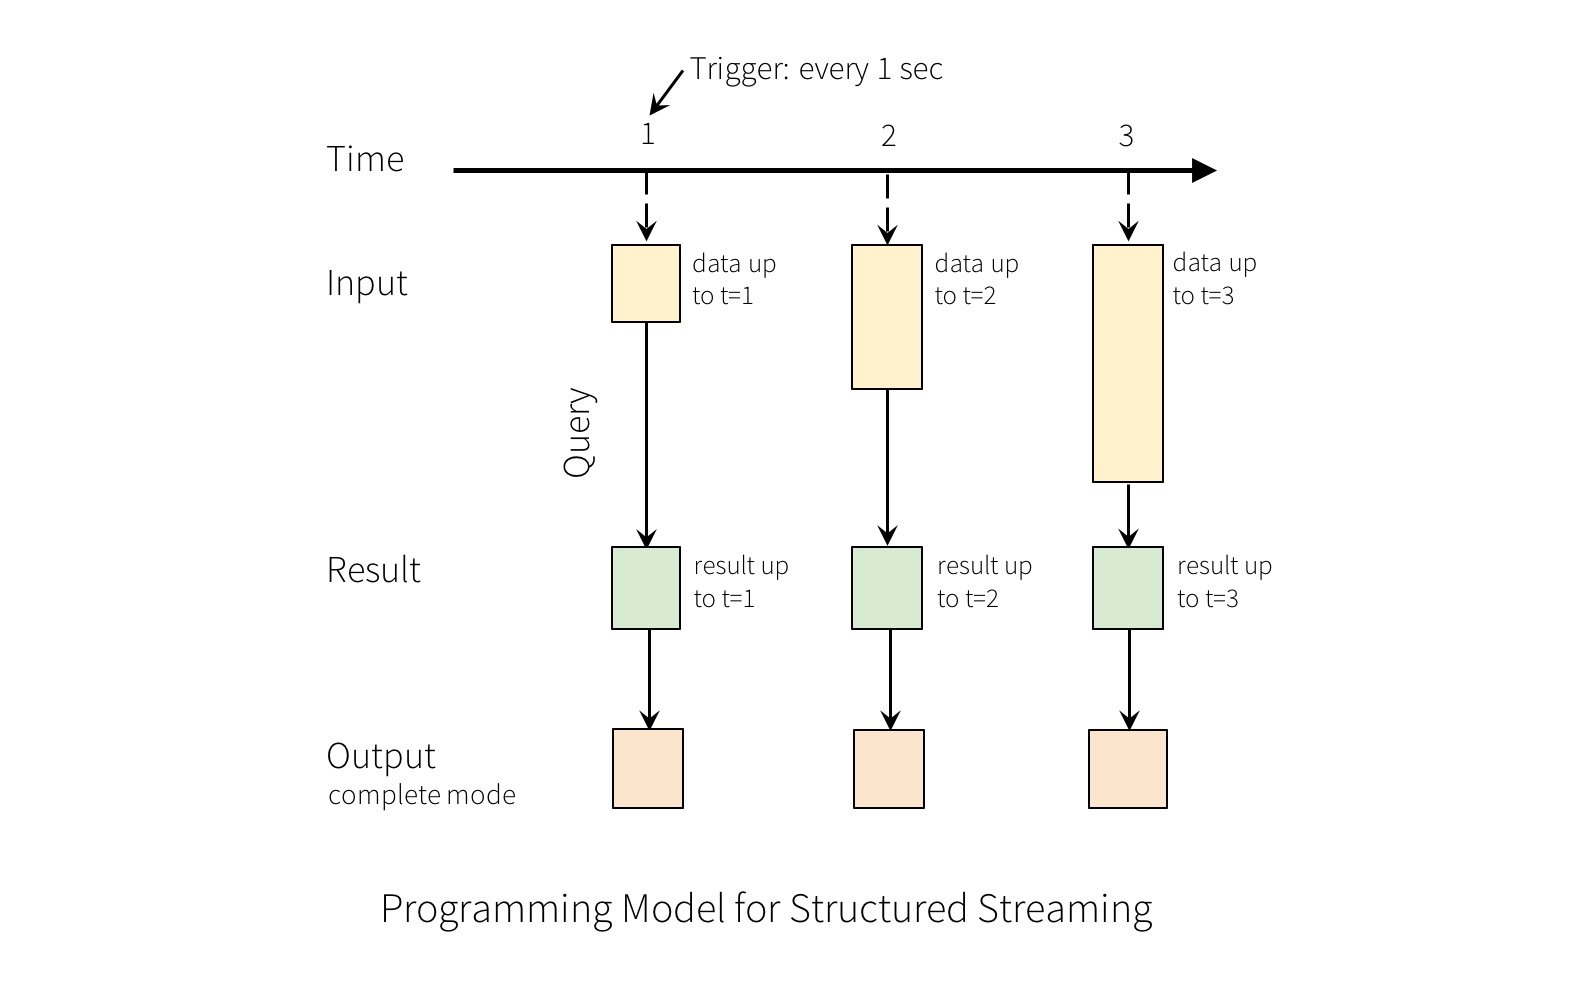

“输出”定义为写到外部存储器的内容。可以在不同的模式下定义输出：

- 完整模式 - 整个更新的结果表将被写入外部存储器。由存储连接器决定如何处理整个表的写入。


- 追加模式 - 仅将自上次触发以来追加在结果表中的新行写入外部存储器。这仅适用于预期结果表中现有行不会更改的查询。


- 更新模式 - 仅自上次触发以来在结果表中已更新的行将被写入外部存储（自Spark 2.1.1起可用）。请注意，这与完成模式的不同之处在于此模式仅输出自上次触发以来已更改的行。如果查询不包含聚合，则等同于追加模式。

请注意，每种模式都适用于某些类型的查询。稍后将对此进行详细讨论。

为了说明此模型的用法，让我们在上面的快速示例的上下文中了解该模型。第一个DataFrame`lines`是输入表，最后一个DataFrame`wordCounts`是结果表。需要注意的是对流：DataFrame`lines`->`wordCounts`的查询是完全一样的，因为它是一个静态的DataFrame。但是，启动此查询时，Spark将连续检查套接字连接中的新数据。如果有新数据，Spark将运行一个“增量”查询，该查询将先前的运行计数与新数据结合起来以计算更新的计数，如下所示。

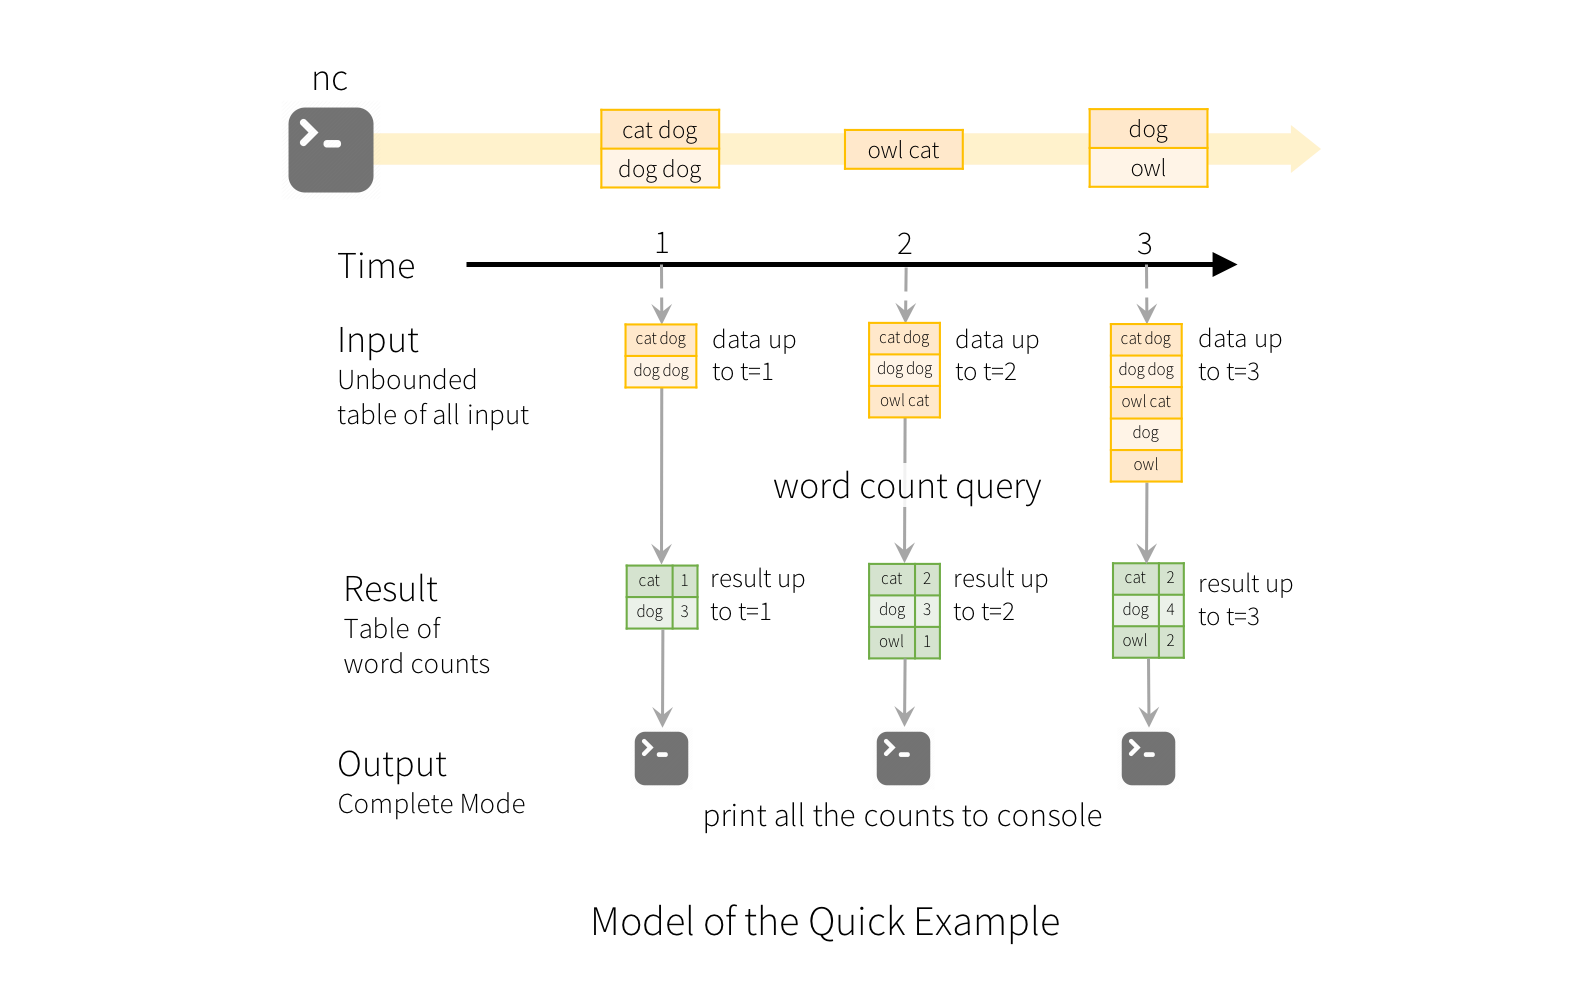

**请注意，Structured Streaming不会实例化整个表**。它从流数据源读取最新的可用数据，对其进行增量处理以更新结果，然后丢弃该源数据。它仅保留更新结果所需的最小中间状态数据（例如，前面示例中的中间计数）。

此模型与许多其他流处理引擎明显不同。许多流系统要求用户自己维护运行中的聚合，因此必须考虑容错和数据一致性（At-Least-Once，At-Most-Once或Exactly-Once）。在此模型中，Spark负责在有新数据时更新结果表，从而使用户免于推理。作为示例，让我们看看该模型如何处理基于事件时间的处理和延迟到达的数据。

### 处理事件时间和延迟数据

事件时间是嵌入数据本身的时间。对于许多应用程序，您可能需要在此事件时间进行操作。例如，如果要获取每分钟由IoT设备生成的事件数，则可能要使用生成数据的时间（即数据中的事件时间），而不是Spark收到数据的时间。此事件时间在此模型中非常自然地表示-设备中的每个事件都是表中的一行，而事件时间是该行中的列值。这允许基于窗口的聚合（例如，每分钟的事件数）只是事件时间列上的一种特殊类型的分组和聚合-每个时间窗口都是一个组，每行可以属于多个窗口/组。因此，

此外，此模型自然会根据事件时间处理比预期晚到达的数据。由于Spark正在更新结果表，因此它具有完全控制权，可在有较晚数据时更新旧聚合，并可以清除旧聚合以限制中间状态数据的大小。从Spark 2.1开始，我们支持水印功能，该功能允许用户指定最新数据的阈值，并允许引擎相应地清除旧状态。这些将在后面的“窗口操作”部分中详细介绍。

### 容错语义

交付端到端的一次语义是Structured Streaming设计背后的主要目标之一。为此，我们设计了Structured Streaming源，接收器和执行引擎，以可靠地跟踪处理的确切进度，以便它可以通过重新启动和/或重新处理来处理任何类型的故障。假定每个流源都有偏移量（类似于Kafka偏移量或Kinesis序列号）以跟踪流中的读取位置。引擎使用检查点和预写日志来记录每个触发器中正在处理的数据的偏移范围。流接收器被设计为是幂等的，用于处理后处理。结合使用可重播的源和幂等的接收器，Structured Streaming可以确保在任何故障下端到端的Exactly-Once语义。

## 使用DataSets和DataFrames的API
从Spark 2.0开始，DataFrame和Dataset可以表示静态的有界数据以及流式无界数据。与静态DataSet/DataFrame相似，您可以使用公共入口点SparkSession（[Scala](https://spark.apache.org/docs/latest/api/scala/org/apache/spark/sql/SparkSession.html)/[Java](https://spark.apache.org/docs/latest/api/java/org/apache/spark/sql/SparkSession.html)/[Python](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SparkSession)/[R](https://spark.apache.org/docs/latest/api/R/sparkR.session.html) docs）从流源创建流DataSet/DataFrame，并对它们应用与静态DataSet/DataFrame相同的操作。如果您不熟悉Datasets/DataFrames，强烈建议您使用[DataFrame/Dataset编程指南](https://spark.apache.org/docs/latest/sql-programming-guide.html)来熟悉它们。

### 创建流DataFrame/DataSet

可以通过由`SparkSession.readStream()`返回的`DataStreamReader`接口（[Scala](https://spark.apache.org/docs/latest/api/scala/org/apache/spark/sql/streaming/DataStreamReader.html)/[Java](https://spark.apache.org/docs/latest/api/java/org/apache/spark/sql/streaming/DataStreamReader.html)/[Python](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.streaming.DataStreamReader)文档）创建流式DataFrame。在R中，使用read.stream()方法。与用于创建静态DataFrame的读取接口类似，您可以指定源的详细信息-数据格式，架构，选项等。


#### 输入源

有一些内置源。

- **文件源** - 读取写入目录的文件作为数据流。文件将按照文件修改时间的顺序进行处理。如果设置`latestFirst`，则顺序将相反。支持的文件格式为文本，CSV，JSON，ORC，Parquet。有关最新列表以及每种文件格式的受支持选项，请参见DataStreamReader界面的文档。请注意，文件必须原子地放置在给定目录中，在大多数文件系统中，这可以通过文件移动操作来实现。


- **Kafka源** - 从Kafka读取数据。它与0.10.0或更高版本的Kafka代理兼容。有关更多详细信息，请参见《[Kafka集成指南](https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html)》。


- **套接字源（用于测试）** - 从套接字连接读取UTF8文本数据。监听服务器套接字位于驱动程序处。请注意，这仅应用于测试，因为这不能提供端到端的容错保证。


- **Rate源（用于测试）** - 以每秒指定的行数生成数据，每个输出行包含`timestamp`和`value`。`timestamp`是包含消息分发时间的`Timestamp`类型，`value`是包含消息计数的`Long`类型，从0开始作为第一行。此源旨在用于测试和基准测试。


某些源不是容错的，因为它们不能保证故障后可以使用检查点偏移来重放数据。参见前面有关容错语义的部分。以下是Spark中所有来源的详细信息。

源|参数|容错性|注意
:--: | :-- | :--: | :--
**文件源**| `path`: 输入目录的路径，并且对所有文件格式都是公用的。<br><br>`maxFilesPerTrigger`: 每个触发器要考虑的新文件的最大数量（默认值: no max）<br><br>`latestFirst`: 是否首先处理最新的新文件，当文件积压很大时很有用（默认值: false）<br><br>`fileNameOnly`: 是否仅根据文件名检查新文件而不是完整路径（默认值: false）。设置为 true 时，以下文件将被视为同一文件，因为它们的文件名"dataset.txt"是相同的:<br>"file:///dataset.txt"<br>"s3://a/dataset.txt"<br>"s3n://a/b/dataset.txt"<br>"s3a://a/b/c/dataset.txt"<br><br>`maxFileAge`: 忽略此文件之前，可以在此目录中找到文件的最大年龄。对于第一批，所有文件将被视为有效。如果`latestFirst`设置为 true 并设置了`maxFilesPerTrigger`，则此参数将被忽略，因为可能会忽略有效且应处理的旧文件。最长期限是相对最新文件的时间戳而不是当前系统的时间戳指定的。（默认值: 1 周）<br><br>`cleanSource`: 此选项用于在处理后清除已完成的文件。<br>可用选项为"archive"，"delete"，"off"。如果未提供该选项，则默认值为"off"。<br>如果提供"archive"，则还必须提供附加选项`sourceArchiveDir`。`sourceArchiveDir`与源 pattern 的目录深度不匹配，其中深度是两个路径上深度的最小值。这将确保存档文件永远不会作为新的源文件包括在内。<br>例如，假设您提供`/hello?/spark/*`作为源 pattern，则`/hello1/spark/archive/dir`不能用作`sourceArchiveDir`的值，因为`/hello?/spark/*`和`/hello1/spark/archive`匹配。`/hello1/spark`也不能用作`sourceArchiveDir`的值，因为`/hello?/spark`和`/hello1/spark`匹配。`/archived/here`可以，因为它不匹配。<br>Spark 将按照其自身路径移动源文件。例如，如果源文件的路径是`/a/b/dataset.txt`存档目录的路径为`/archived/here`，文件将被移至`/archived/here/a/b/dataset.txt`。<br>注意: 存档（通过移动）或删除完成的文件都会在每个微批处理中引入开销（即使是在单独的线程中发生，也会降低速度），因此在启用此功能之前，您需要了解文件系统中每个操作的成本项。另一方面，启用此选项将减少列出源文件的成本，这可能是一项昂贵的操作。<br>文件清除器中使用的线程数可以通过`spark.sql.streaming.fileSource.cleaner.numThreads`（默认值: 1）进行配置。<br>注意 2: 启用此选项时，不应从多个源或查询中使用源路径。同样，您必须确保源路径与文件流接收器的输出目录中的任何文件都不匹配。<br>注意 3: 删除和移动动作都是尽力而为。不删除或移动文件不会使流查询失败。在某些情况下，Spark 可能无法清理某些源文件-例如，应用程序无法正常关闭，排队的文件太多，无法清理。<br><br>有关特定于文件格式的选项，请参见`DataStreamReader`（[Scala](https://spark.apache.org/docs/latest/api/scala/org/apache/spark/sql/streaming/DataStreamReader.html)/[Java](https://spark.apache.org/docs/latest/api/java/org/apache/spark/sql/streaming/DataStreamReader.html)/[Python](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.streaming.DataStreamReader)/[R](https://spark.apache.org/docs/latest/api/R/read.stream.html)）中的相关方法。"parquet"格式选项请参见`DataStreamReader.parquet()`。<br><br>此外，有些会话配置会影响某些文件格式。有关更多详细信息，请参见《[SQL 编程指南](https://spark.apache.org/docs/latest/sql-programming-guide.html)》。例如，对于"parquet"，请参阅[parquet 配置](https://spark.apache.org/docs/latest/sql-data-sources-parquet.html#configuration)部分。<br> | Yes | 支持全局路径，但不支持多个逗号分隔的路径/全局路径。
**套接字源**| `host`: 要连接的主机，必须指定<br>`port`: 要连接的端口，必须指定 | No | --
**Rate源**| `rowsPerSecond`（例如100，默认值：1）：每秒应生成多少行。<br><br>`rampUpTime`（例如5s，默认值：0s）：在发送速度达到`rowsPerSecond`之前要加速多长时间，使用比秒更精细的粒度将被截断为整数秒。<br><br>`numPartitions`（例如10，默认值：Spark的默认并行度）：生成的行的分区数。<br><br>源将尽最大努力达到目标`rowsPerSecond`，但是查询可能受到资源的限制，并且`numPartitions`可以进行调整以帮助达到所需的速度。 | Yes | --
**Kafka源源**| 见《[Kafka集成指南](https://spark.apache.org/docs/latest/structured-streaming-kafka-integration.html) | Yes | --




这里有些例子。

```python
spark = SparkSession. ...

# Read text from socket
socketDF = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

socketDF.isStreaming()    # Returns True for DataFrames that have streaming sources

socketDF.printSchema()

# Read all the csv files written atomically in a directory
userSchema = StructType().add("name", "string").add("age", "integer")
csvDF = spark \
    .readStream \
    .option("sep", ";") \
    .schema(userSchema) \
    .csv("/path/to/directory")  # Equivalent to format("csv").load("/path/to/directory")
```

这些示例生成未类型化的流式DataFrame，这意味着在编译时不检查DataFrame的架构，仅在提交查询时在运行时检查它。有些操作（如map，flatMap等）需要在编译时知道类型。为此，可以使用与静态DataFrame相同的方法将这些未类型化的流式DataFrames转换为类型化的流式DataSets。有关更多详细信息，请参见《[SQL编程指南](https://spark.apache.org/docs/latest/sql-programming-guide.html)》。此外，本文档后面将讨论有关受支持的流源的更多详细信息。

#### 流DataFrame/DataSet的schema推断和分区

DataFrame中的数据结构信息，即为schema。

默认情况下，从基于文件的源的Structured Streaming需要您指定schema，而不是依靠Spark自动进行推断。此限制确保即使在发生故障的情况下，也将一致的架构用于流查询。对于临时用例，可以通过设置spark.sql.streaming.schemaInference为true来重新启用schema推断。

当存在命名/key=value/的子目录时，将发生分区，并且列表将自动递归到这些目录中。如果这些列出现在用户提供的schema中，Spark将根据读取文件的路径来填充它们。启动查询时，必须存在组成分区方案的目录，并且这些目录必须保持静态。例如，当/data/year=2015/存在时添加/data/year=2016/是可行的，但改变分区列（如创建目录/data/date=2016-04-17/）是无效的。


### 流DataFrame/DataSet的操作

对于流式DataFrames/DataSets适用操作包括：无类型操作、类SQL操作（例如select，where，groupBy），类RDD操作（例如map，filter，flatMap）。有关更多详细信息，请参见[SQL编程指南](https://spark.apache.org/docs/latest/sql-programming-guide.html)。

#### 基本操作 - 选择，投影，聚合

流上支持DataFrame/Dataset上的大多数常见操作。

```python
df = ...  # streaming DataFrame with IOT device data with schema { device: string, deviceType: string, signal: double, time: DateType }

# Select the devices which have signal more than 10
df.select("device").where("signal > 10")

# Running count of the number of updates for each device type
df.groupBy("deviceType").count()
```

您还可以将流DataFrame/DataSet注册为临时视图，然后在其上应用SQL命令。

```python
df.createOrReplaceTempView("updates")
spark.sql("select count(*) from updates")  # returns another streaming DF
```

注意，您可以使用`df.isStreaming`来确定DataFrame/Dataset是否具有流数据。

```python
df.isStreaming()
```

#### 基于事件时间的窗口操作

滑动事件时间窗口上的聚合使用Structured Streaming非常简单，并且与分组聚合非常相似。在分组聚合中，在用户指定的分组列中为每个唯一值维护聚合值（例如，计数）。在基于窗口的聚合的情况下，行事件时间所属的每个窗口都会维护聚合值。让我们通过插图来了解这一点。

想象一下我们的快速示例已被修改，并且流现在包含行以及生成行的时间。我们希望在10分钟的窗口内对单词进行计数，而不是运行字数统计，每5分钟更新一次。也就是说，在10分钟窗口12:00-12:10、12:05-12:15、12:10-12:20等之间接收的单词中的单词计数。请注意，12:00-12:10表示数据12:00之后但12:10之前到达。现在，考虑在12:07收到的单词。此字应增加与两个窗口12:00-12:10和12:05-12:15对应的计数。因此，计数将通过分组键（即单词）和窗口（可以从事件时间计算）来索引。

结果表如下所示。

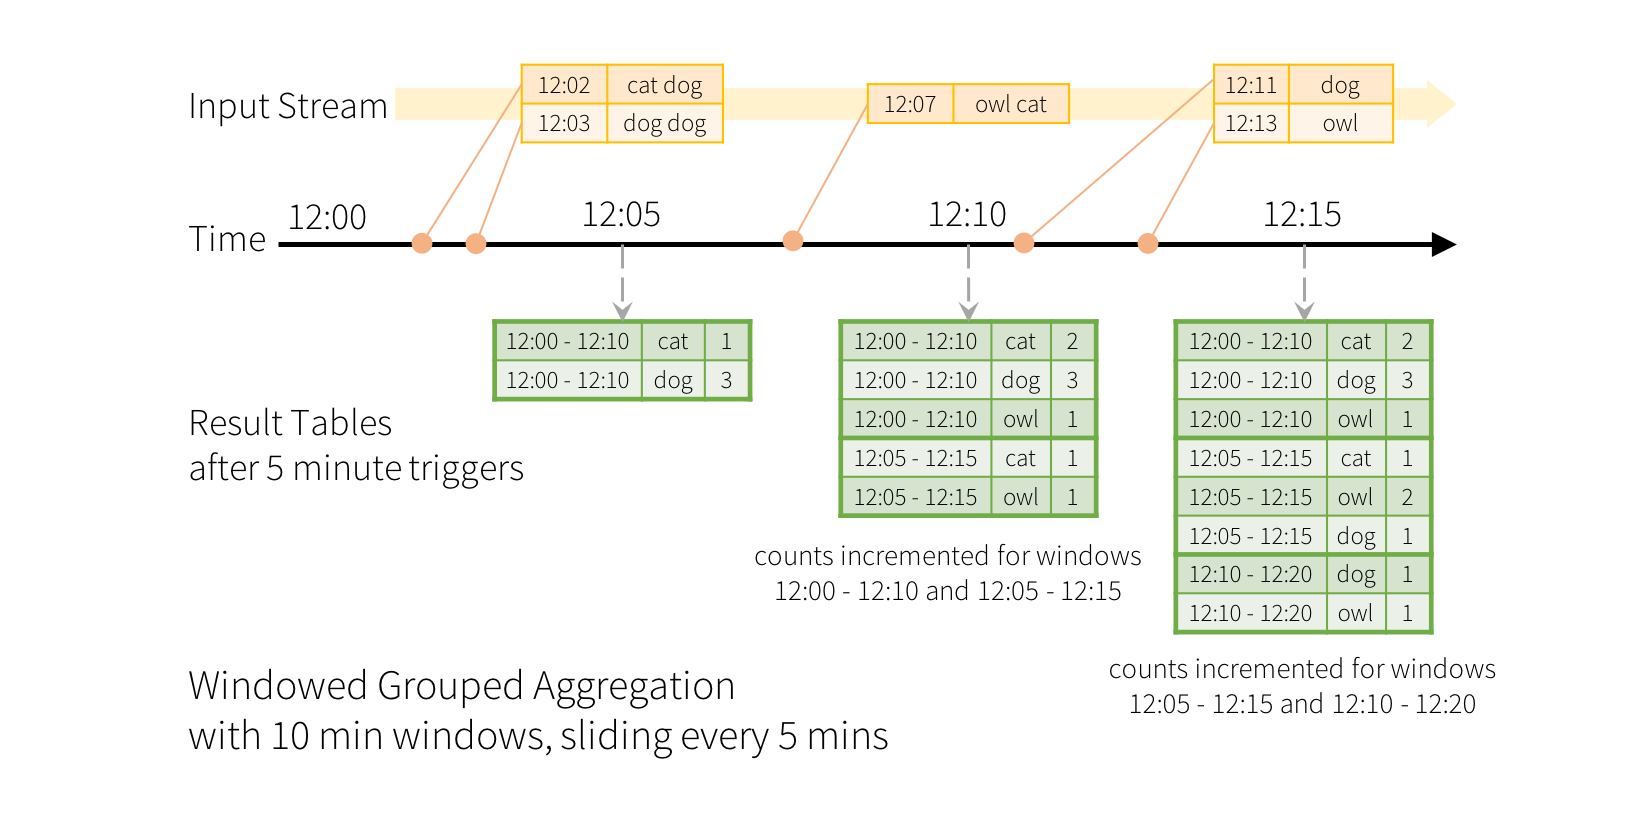

由于此窗口化类似于分组，因此在代码中，您可以使用`groupBy()`和`window()`操作来表示窗口化聚合。

```python
words = ...  # streaming DataFrame of schema { timestamp: Timestamp, word: String }

# Group the data by window and word and compute the count of each group
windowedCounts = words.groupBy(
    window(words.timestamp, "10 minutes", "5 minutes"),
    words.word
).count()
```

##### 处理后期数据和加水印

现在考虑如果事件延迟到达应用程序会发生什么。例如，应用程序可以在12:11接收在12:04（即事件时间）生成的单词。应用程序应使用12:04而不是12:11来更新窗口的旧计数12:00 - 12:10。这在我们基于窗口的分组中很自然地发生——Structured Streaming可以长时间保持部分聚合的中间状态，以便后期数据可以正确更新旧窗口的聚合，如下所示。

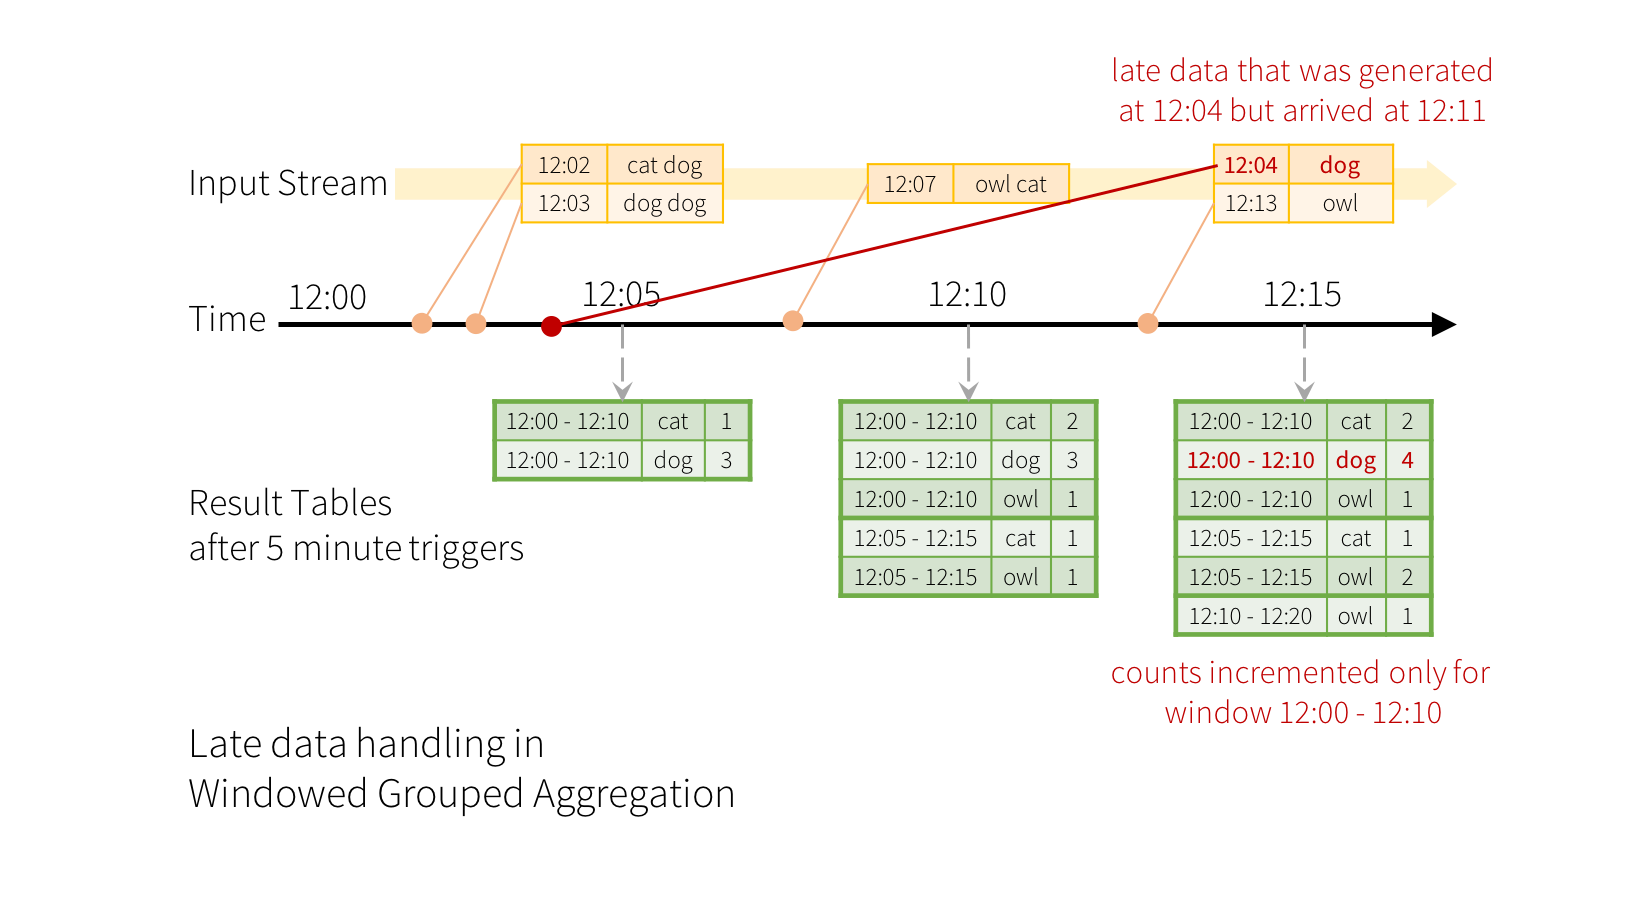

但是，要连续几天运行此查询，系统必须限制其累积的中间内存状态量。这意味着系统需要知道何时可以从内存中的状态删除旧聚合，因为应用程序将不再接收该聚合的最新数据。为了实现这一点，我们在Spark 2.1中引入了水印功能，该功能使引擎自动跟踪数据中的当前事件时间，并尝试相应地清除旧状态。您可以通过指定事件时间列和有关事件时间期望数据延迟的阈值来定义查询的水印。对于在时间T结束的特定窗口，引擎将维持状态并允许以后的数据更新状态，直到(max event time seen by the engine - late threshold > T)。换句话说，阈值内的延迟数据将被聚合，但阈值后的数据将开始被丢弃。让我们通过一个例子来理解这一点。我们可以使用`withWatermark()`以下示例在上一个示例中轻松定义水印。

```python
words = ...  # streaming DataFrame of schema { timestamp: Timestamp, word: String }

# Group the data by window and word and compute the count of each group
windowedCounts = words \
    .withWatermark("timestamp", "10 minutes") \
    .groupBy(
        window(words.timestamp, "10 minutes", "5 minutes"),
        words.word) \
    .count()
```

在此示例中，我们将在“timestamp”列的值上定义查询的水印，还将“10 minutes”定义为允许数据晚到的阈值。如果此查询在“更新输出”模式下运行，则引擎将在“结果表”中保持窗口的更新计数，直到该窗口早于水印为止，即该时间滞后于“列”中的当前事件时间。时间戳”的时间缩短10分钟。这是一个例子。

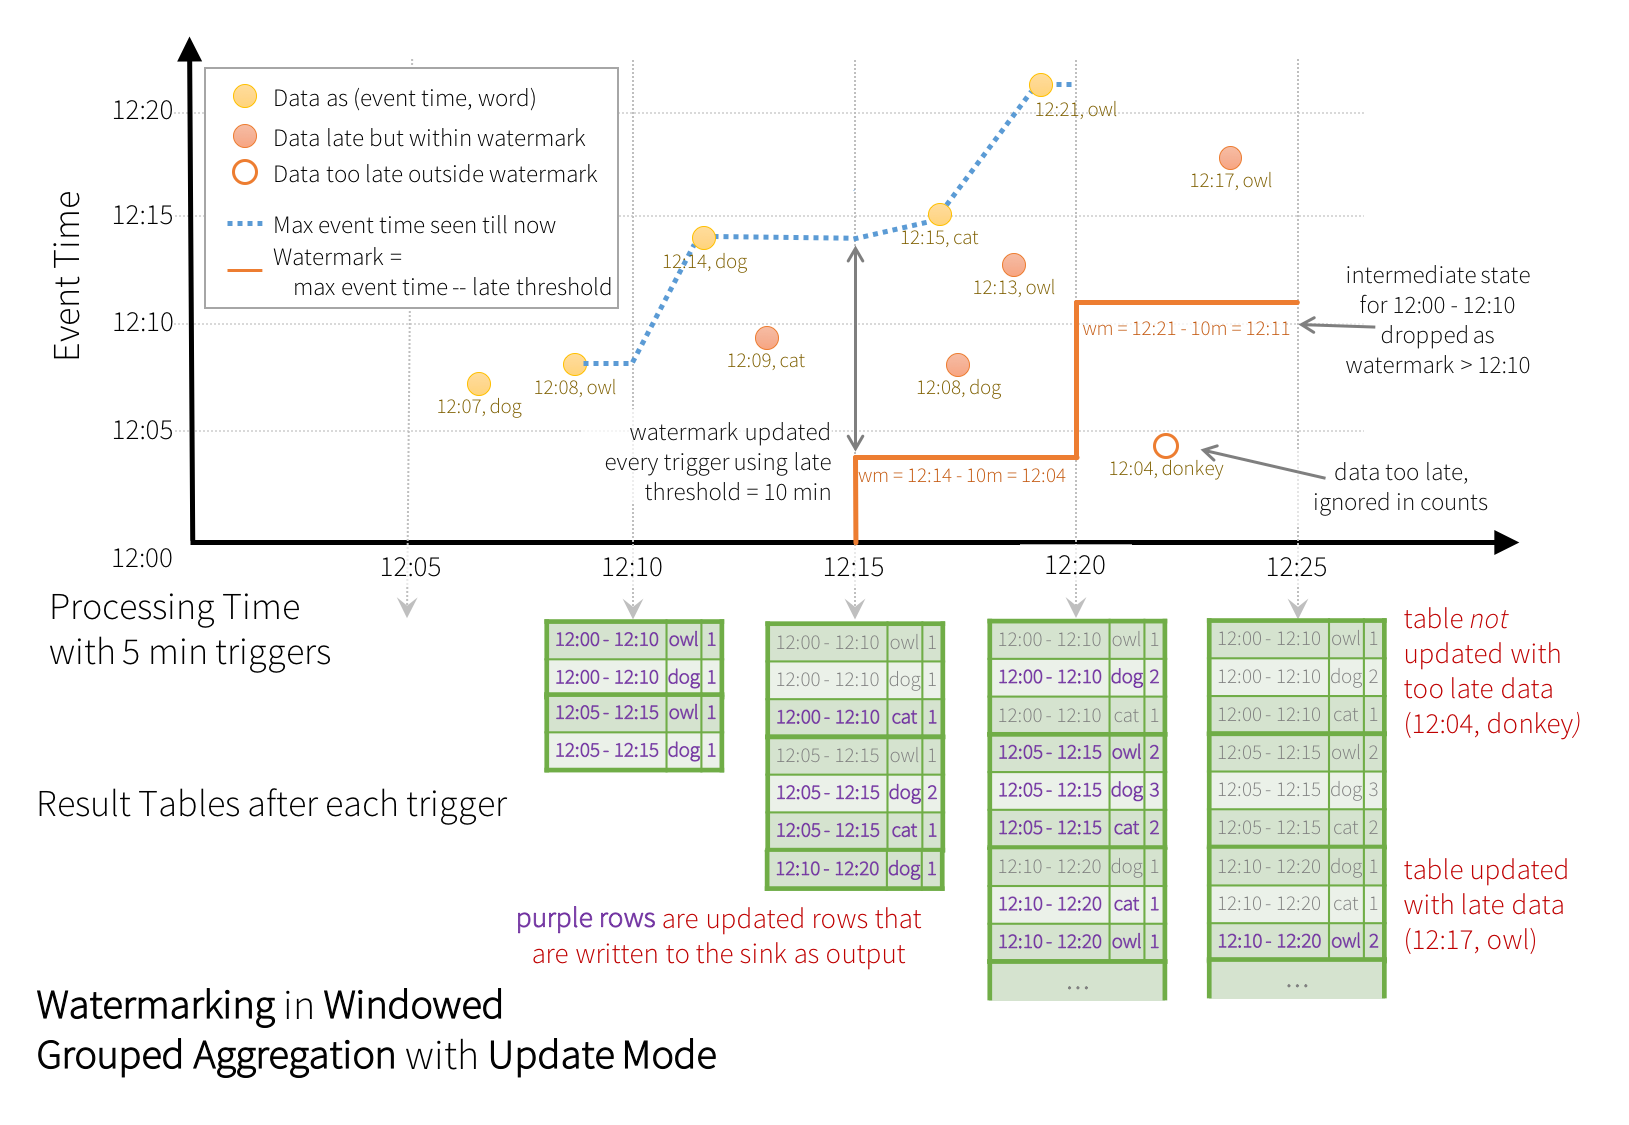

如图所示，引擎跟踪的最大事件时间是蓝色虚线，(max event time - '10 mins')在每次触发开始时设置的水印是红线。例如，当引擎观察到数据时(12:14, dog)，它将下一个触发器的水印设置为12:04。此水印可让引擎再保持10分钟的中间状态，以便对较晚的数据进行计数。例如，数据(12:09, cat)不正确且延迟，并且落在s12:00 - 12:10和12:05 - 12:15的窗口中。在此次触发中，由于它仍然在水印12:04之前，因此引擎仍将中间计数保持为状态并正确更新相关窗口的计数。但是，当水印更新为12:11时，清除了(12:00 - 12:10)窗口的中间状态，并且所有后续数据（例如(12:04, donkey)）都被认为“为时已晚”，因此被忽略。请注意，在每次触发后，更新的计数（即紫色行）都会写入更新，作为更新输出指示的触发输出。

某些接收器（例如文件）可能不支持更新模式所需的细粒度更新。为了与他们一起工作，我们还支持追加模式，其中仅将最终计数写入接收器。如下所示。

请注意，withWatermark在非流DataSet上使用是no-op。由于水印不应以任何方式影响任何批量查询，因此我们将直接忽略它。

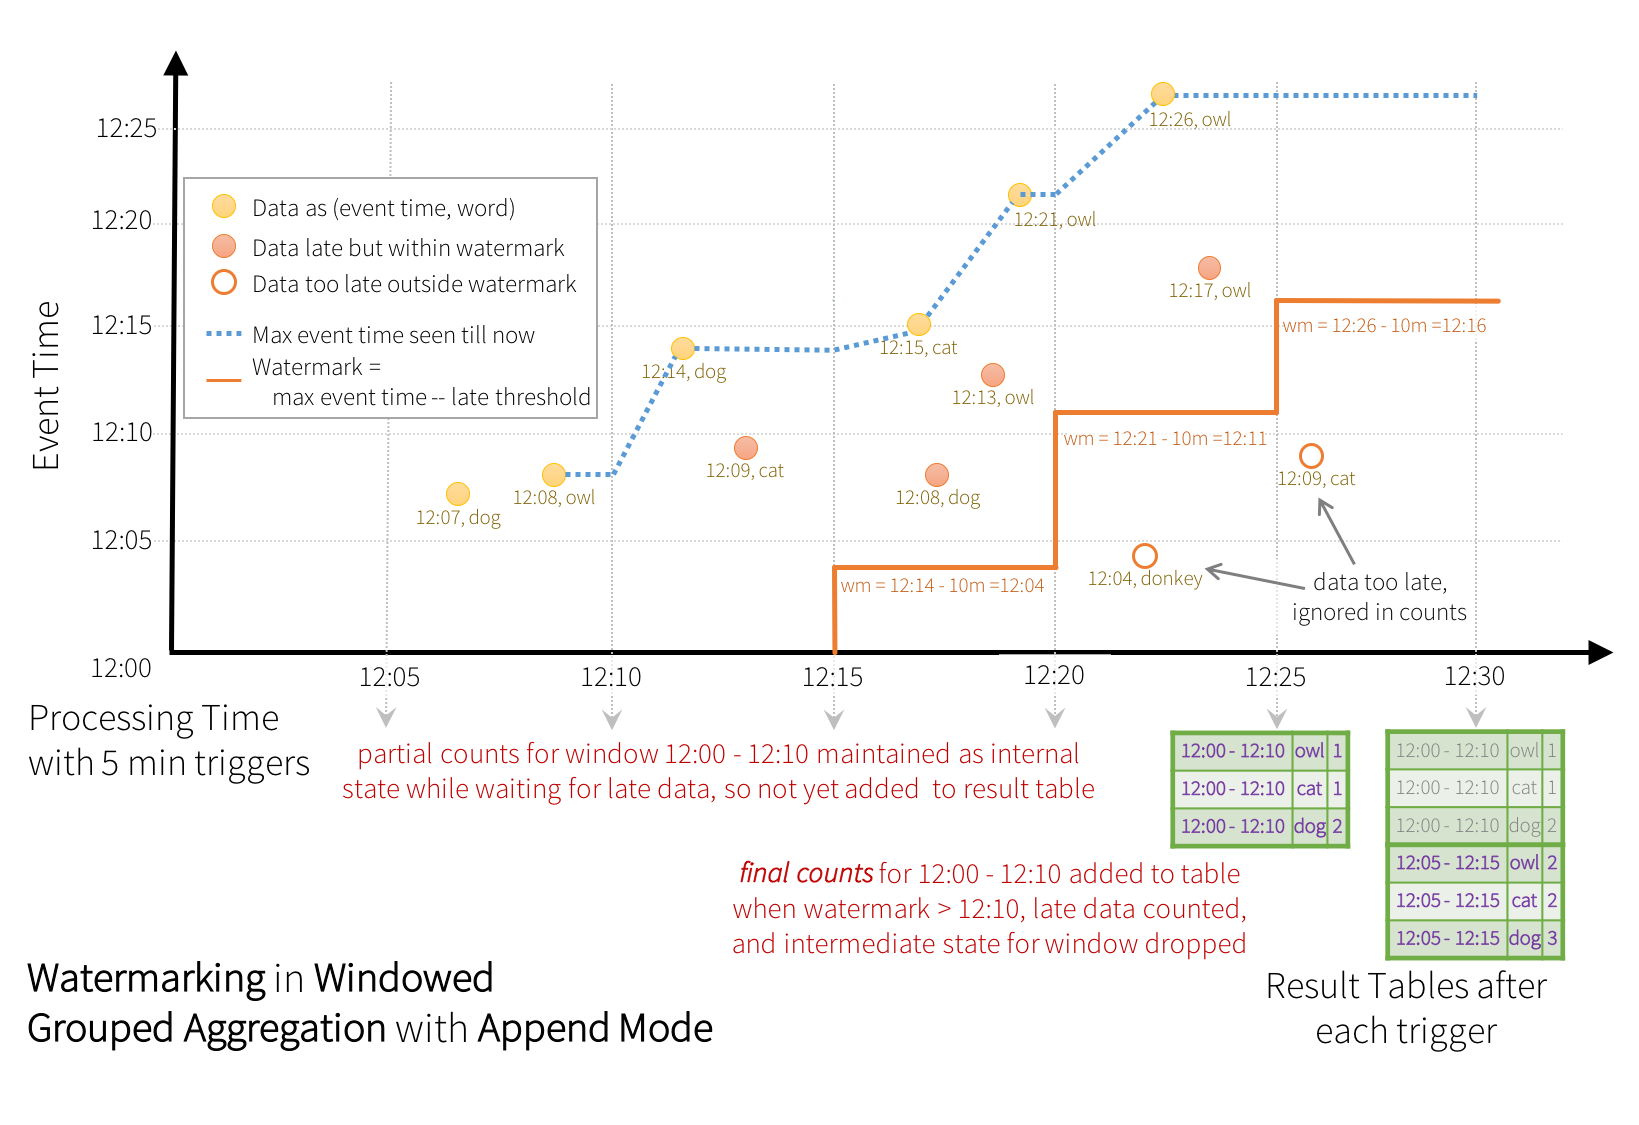

与之前的更新模式类似，引擎为每个窗口维护中间计数。但是，部分计数不会更新到结果表，也不会写入接收器。引擎等待“10 minutes”后才进行计数，然后删除窗口<水印的的中间状态，然后将最终计数附加到结果表/接收器。例如，12:00 - 12:10仅在将水印更新为之后，窗口的最终计数才添加到结果表中12:11。

###### 加水印以清除聚合状态的条件

需要注意的是，必须满足以下条件才能使用水印清除聚合查询中的状态（从Spark 2.1.1开始，将来可能会更改）。

- **输出模式必须为追加或更新**。完整模式要求保留所有聚合数据，因此不能使用水印删除中间状态。有关每种输出模式的语义的详细说明，请参见“输出模式”部分。

- 聚合必须在“event-time”列或“event-time”列的window上。

- `withWatermark`必须在与汇总中使用的时间戳列相同的列上调用。例如， `df.withWatermark("time", "1 min").groupBy("time2").count()`在附加输出模式下无效，因为水印是在与聚合列不同的列上定义的。

- `withWatermark`必须在使用水印详细信息的聚合之前调用。例如，`df.groupBy("time").count().withWatermark("time", "1 min")`在追加输出模式下无效。

###### 带水印的聚合的语义保证

水印延迟（通过withWatermark设置）为“2 hours”，确保引擎永远不会丢弃任何延迟少于2小时的数据。换句话说，任何（在事件时间方面）比最新的处理数据晚2小时以内的数据，都可以保证得到聚合。

但是，保证仅在一个方向上严格。延迟超过2小时的数据不能保证被删除；它可能会或可能不会聚合。数据延迟更多，引擎处理数据的可能性越小。

### 联接操作

Structured Streaming支持将流DataSet/DataFrame与静态DataSet/DataFrame以及另一个流DataSet/DataFrame连接在一起。流联接的结果是增量生成的，类似于上一节中的流聚合的结果。在本节中，我们将探讨在上述情况下支持哪些类型的联接（即内联接，外联接等）。请注意，在所有受支持的联接类型中，使用流DataSet/DataFrame进行联接的结果将与使用包含流中相同数据的静态Dataset/DataFrame进行联接的结果完全相同。

#### 流-静态联接

自从Spark 2.0引入以来，Structured Streaming已支持流和静态DataFrame/Dataset之间的联接（内联接和某种类型的外联接）。这是一个简单的例子。

```python
staticDf = spark.read. ...
streamingDf = spark.readStream. ...
streamingDf.join(staticDf, "type")  # inner equi-join with a static DF
streamingDf.join(staticDf, "type", "right_join")  # right outer join with a static DF
```

请注意，流静态联接不是有状态的，因此不需要状态管理。但是，尚不支持某些类型的流静态外联接。这些在本“连接”部分的末尾列出。

#### 流-流联接

在Spark 2.3中，我们添加了对流流连接的支持，也就是说，您可以连接两个流DataSet/ DataFrame。在两个数据流之间生成联接结果的挑战在于，在任何时间点，联接双方的DataSet视图都不完整，这使得在输入之间查找匹配项变得更加困难。从一个输入流中接收到的任何行都可以与另一输入流中任何将来要接收的行相匹配。因此，对于这两个输入流，我们将过去的输入作为流状态进行缓冲，以便我们可以将每个将来的输入与过去的输入进行匹配，从而生成合并的结果。此外，类似于流式聚合，我们会自动处理较晚的乱序数据，并可以使用水印限制状态。让我们讨论支持的流连接的不同类型以及如何使用它们。

##### 内联接，带可选水印

支持任何类型的列上的内部连接以及任何类型的连接条件。但是，随着流的运行，流状态的大小将无限期增长，因为必须保存所有过去的输入，因为任何新输入都可以与过去的任何输入匹配。为了避免无界状态，您必须定义其他联接条件，以使无限期的旧输入无法与将来的输入匹配，因此可以从状态中清除它们。换句话说，您将必须在联接中执行以下附加步骤。

1. 在两个输入上定义水印延迟，以便引擎知道输入可以延迟多久（类似于流聚合）

2. 定义两个输入之间的事件时间约束，以便引擎可以确定何时不需要与另一个输入匹配的一个输入的旧行（即，不满足时间约束）。可以通过两种方式之一来定义此约束。

    1. 时间范围加入条件（例如...JOIN ON leftTime BETWEEN rightTime AND rightTime + INTERVAL 1 HOUR），

    2. 加入事件时间窗口（例如...JOIN ON leftTimeWindow = rightTimeWindow）。

让我们通过一个例子来理解这一点。

假设我们想将广告的曝光流（显示广告时）与广告的用户点击流相关联，因为曝光可导致可获利的点击。为了允许在此流-流连接中进行状态清除，您将必须指定水印延迟和时间限制，如下所示。

水印延迟：曝光和相应的点击在事件发生时间中可能分别是迟到/乱序，最多分别为2和3个小时。

事件时间范围条件：假设在相应的曝光之后的0秒到1小时的时间范围内可以发生点击。

代码看起来像这样。

```python
from pyspark.sql.functions import expr

impressions = spark.readStream. ...
clicks = spark.readStream. ...

# Apply watermarks on event-time columns
impressionsWithWatermark = impressions.withWatermark("impressionTime", "2 hours")
clicksWithWatermark = clicks.withWatermark("clickTime", "3 hours")

# Join with event-time constraints
impressionsWithWatermark.join(
  clicksWithWatermark,
  expr("""
    clickAdId = impressionAdId AND
    clickTime >= impressionTime AND
    clickTime <= impressionTime + interval 1 hour
    """)
)
```

###### 带水印的流-流内联接的语义保证

这类似于水印对聚合提供的保证。水印延迟为“2小时”可确保引擎永远不会丢弃少于2小时的任何数据。但是延迟超过2小时的数据可能会或可能不会得到处理。

##### 外联接，带水印

对于内联接，水印+事件时间约束是可选的，对于左右外联接，必须指定它们。这是因为在外联接中若生成NULL结果，引擎必须知道输入行将来什么时候不匹配。因此，必须指定水印+事件时间约束以生成正确的结果。因此，带有外联接的查询看起来与前面的广告获利示例非常相似，不同之处在于，将有一个附加参数将其指定为外联接。

```python
impressionsWithWatermark.join(
  clicksWithWatermark,
  expr("""
    clickAdId = impressionAdId AND
    clickTime >= impressionTime AND
    clickTime <= impressionTime + interval 1 hour
    """),
  "leftOuter"                 # can be "inner", "leftOuter", "rightOuter"
)
```

###### 带水印的流-流外联接的语义保证

关于水印延迟以及数据是否会丢失，外联接与内联接具有相同的保证。

###### 注意事项

关于如何生成外部结果，有一些重要的特性需要注意。

- 外部NULL结果的生成延迟取决于指定的水印延迟和时间范围条件。这是因为引擎必须等待很长时间才能确保没有匹配项，并且将来将不再有匹配项。

- 在微批处理引擎的当前实现中，水印在微批处理的末尾进行，下一个微批处理使用更新的水印来清理状态并输出外部结果。由于我们仅在有新数据要处理时才触发微批处理，因此如果流中未接收到新数据，则外部结果的生成可能会延迟。简而言之，如果连接的两个输入流中的任何一个在一段时间内未接收到数据，则外部（两种情况，左或右）输出可能会延迟。

##### 流查询中的联接支持矩阵

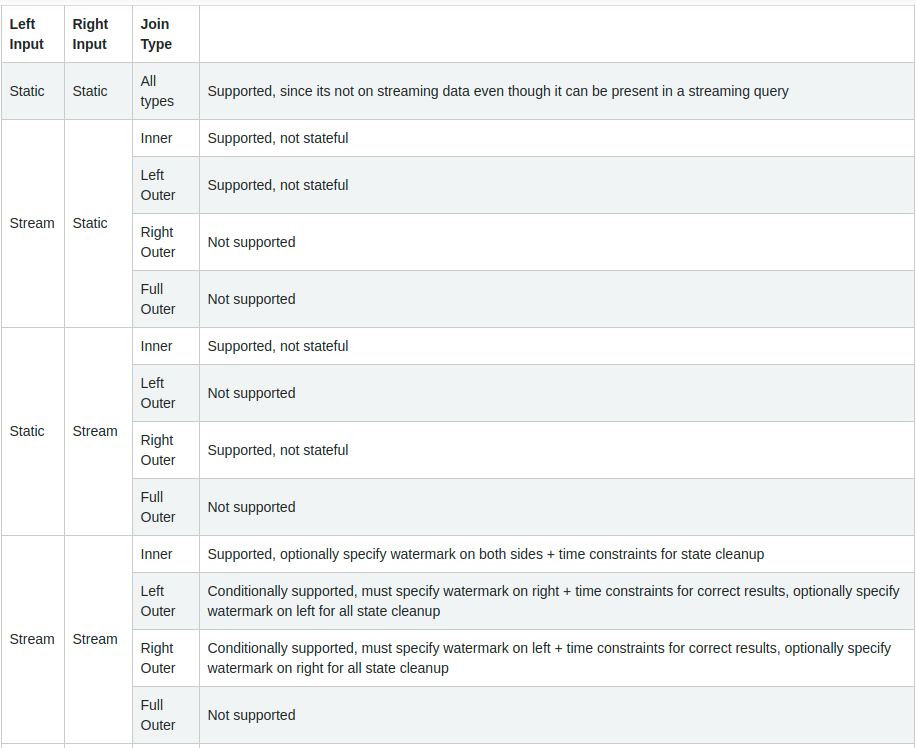

有关支持的联接的其他详细信息：

- 联接可以级联，即可以执行`df1.join(df2, ...).join(df3, ...).join(df4, ....)`。

- 从Spark 2.4开始，仅当查询处于Append输出模式时才能使用联接。尚不支持其他输出模式。

- 从Spark 2.4开始，在连接之前不能使用其他非类map的操作。以下是一些不能使用的示例。

    - 联接前不能使用流式聚合。

    - 联接前不能在更新模式下使用mapGroupsWithState和flatMapGroupsWithState。

### 去重操作

您可以使用事件中的唯一标识符对数据流中的记录进行去重。这与使用唯一标识符列的静态去重完全相同。该查询将存储以前记录中必要的数据量，以便可以过滤重复记录。与聚合类似，您可以在带有或不带有水印的情况下使用去重。

- 使用水印 - 如果在重复记录到达的最晚时间上有上限，则可以在事件时间列上定义水印，然后使用guid和事件时间列进行去重。该查询将使用水印从过去的记录中删除旧的状态数据，而这些数据将不再重复。这限制了查询必须维护的状态量。

- 没有水印 - 由于没有重复记录何时到达的限制，因此查询将所有过去记录的数据存储为状态。

```python
streamingDf = spark.readStream. ...

# Without watermark using guid column
streamingDf.dropDuplicates("guid")

# With watermark using guid and eventTime columns
streamingDf \
  .withWatermark("eventTime", "10 seconds") \
  .dropDuplicates("guid", "eventTime")
```

### 处理多个水印的策略

流查询可以具有多个输入流，这些输入流可以合并或联接在一起。每个输入流都可以具有不同的延迟阈值，以进行有状态操作。您可以`withWatermarks("eventTime", delay)`在每个输入流上使用指定这些阈值。例如，考虑一个在inputStream1和inputStream2的联接流的查询。

执行查询时，Structured Streaming分别跟踪每个输入流中出现的最大事件时间，根据相应的延迟计算水印，并选择单个全局水印用于状态操作。默认情况下，选择最小值作为全局水印，因为如果其中一个流落后于其他流（例如，其中一个流由于上游故障而停止接收数据），它将确保没有数据因延迟被丢弃。换句话说，全局水印将安全地以最慢的流的速度移动，并且查询输出将因此而延迟。

但是，在某些情况下，即使这意味着从最慢的流中删除数据，您可能也想获得更快的结果。从Spark 2.4开始，您可以通过将SQL配置`spark.sql.streaming.multipleWatermarkPolicy`设置为max（默认值为min）来设置多重水印策略，以选择最大值作为全局水印。这使全局水印以最快的速度移动。但是，副作用是，速度较慢的流中的数据将被大量丢弃。因此，请谨慎使用此配置。

### 任意状态操作

许多用例需要比聚合更高级的状态操作。例如，在许多用例中，您必须跟踪事件数据流中的会话。为了进行这种会话化，您将必须将任意类型的数据保存为状态，并在每个触发中使用数据流事件对状态执行任意操作。从Spark 2.2开始，可以使用操作`mapGroupsWithState`和更强大的操作`flatMapGroupsWithState`来完成此操作。两种操作都允许您将用户定义的代码应用于分组的DataSet以更新用户定义的状态。有关更多具体细节，请查看API文档（Scala/Java）和示例（Scala/Java）。

尽管Spark无法检查并强制执行，但应根据输出模式的语义来实现状态功能。例如，在更新模式下，Spark并不希望状态函数发出比当前水印还要早的记录延迟加上允许的后期记录延迟的行，而在追加模式下，状态函数不会发出这些行。

### 不支持的操作

流DataFrame/DataSet不支持一些DataFrame/DataSet操作。其中一些如下。

流DataSet尚不支持多个流聚合（即，流DF上的聚合链）。

流DataSet不支持限制和前N行。

不支持对流DataSet的不同操作。

仅在聚合之后且在“完整输出模式”下，流DataSet才支持排序操作。

不支持流DataSet上很少类型的外联接。有关更多详细信息，请参见“联接操作”部分中的支持矩阵。

此外，有些DataSet方法不适用于流DataSet。它们是将立即运行查询并返回结果的操作，这对于流DataSet没有意义。而是可以通过显式启动流查询来完成这些功能（有关此内容，请参见下一节）。

count()-无法从流DataSet中返回单个计数。相反，使用ds.groupBy().count()会返回包含运行计数的流DataSet。

foreach()-改为使用ds.writeStream.foreach(...)（请参阅下一节）。

show() -而是使用控制台接收器（请参阅下一节）。

如果尝试这些操作中的任何一个，您将看到AnalysisException类似的“流DataFrame/DataSet不支持操作XYZ”的信息。尽管将来的Spark版本可能会支持其中一些功能，但从根本上讲，还有一些功能很难有效地在流数据上实现。例如，不支持对输入流进行排序，因为它需要跟踪流中接收到的所有数据。因此，从根本上讲，这很难有效执行。

### 全局水印的局限性

在追加模式下，如果有状态操作发出的行早于当前水印加上允许的较晚记录延迟，则它们将在下游有状态操作中“滞后行”（因为Spark使用全局水印）。请注意，这些行可能会被丢弃。这是全局水印的限制，并且有可能导致正确性问题。

当Spark检测到这种模式时，Spark将检查查询的逻辑计划并记录警告。

以下任何有状态操作之后的任何有状态操作都可能出现此问题：

- 追加模式下的流式聚合
- 流流外联接
- `mapGroupsWithState`和`flatMapGroupsWithState`处于Append模式（取决于状态功能的实现）

由于Spark无法检查mapGroupsWithState/flatMapGroupsWithState的状态函数，Spark假设如果操作员使用Append模式，则状态函数将发出晚行。

有一个已知的解决方法：将有状态运算符的流式查询分为多个查询，并确保每个查询的端到端Exactly-Once。确保对上一个查询精确地一次端到端是可选的。

### 开始流查询

一旦定义了最终结果DataFrame/Dataset，剩下的一切就是您开始进行流计算。为此，您必须使用通过返回的DataStreamWriter （Scala/Java/Python文档）Dataset.writeStream()。您必须在此界面中指定以下一项或多项。

输出接收器的详细信息：数据格式，位置等。

输出模式：指定要写入输出接收器的内容。

查询名称：（可选）指定查询的唯一名称以进行标识。

触发间隔：（可选）指定触发间隔。如果未指定，则先前的处理完成后，系统将检查新数据的可用性。如果由于之前的处理尚未完成而错过了触发时间，则系统将立即触发处理。

检查点位置：对于某些可以确保端到端容错的输出接收器，请指定系统将在其中写入所有检查点信息的位置。这应该是与HDFS兼容的容错文件系统中的目录。下一节将详细讨论检查点的语义。

#### 输出方式

有几种类型的输出模式。

追加模式（默认） -这是默认模式，在该模式下，仅将自上次触发以来添加到结果表中的新行输出到接收器。只有那些添加到“结果表”中的行永不改变的查询才支持此功能。因此，此模式保证每行仅输出一次（假定容错接收器）。例如，查询只select， where，map，flatMap，filter，join，等会支持追加模式。

完成模式-每次触发后，整个结果表将输出到接收器。聚合查询支持此功能。

更新模式-（自Spark 2.1.1起可用）仅从上次触发以来已更新的结果表中的行将输出到接收器。在将来的版本中将添加更多信息。

不同类型的流查询支持不同的输出模式。这是兼容性矩阵。

#### 输出接收器

有几种类型的内置输出接收器。

-文件接收器-将输出存储到目录。
```python
writeStream
    .format("parquet")        // can be "orc", "json", "csv", etc.
    .option("path", "path/to/destination/dir")
    .start()
```
- Kafka接收器-将输出存储到Kafka中的一个或多个主题。
```python
writeStream
    .format("kafka")
    .option("kafka.bootstrap.servers", "host1:port1,host2:port2")
    .option("topic", "updates")
    .start()
```
- Foreach接收器-对输出中的记录运行任意计算。有关更多详细信息，请参见本节后面的内容。
```python
writeStream
    .foreach(...)
    .start()
```
-控制台接收器（用于调试） -每次有触发器时，将输出打印到控制台/ stdout。支持追加和完整输出模式。由于每次触发后都会收集整个输出并将其存储在驱动程序的内存中，因此应在数据量较小时用于调试目的。
```python
writeStream
    .format("console")
    .start()
```
-内存接收器（用于调试） -输出作为内存表存储在内存中。支持追加和完整输出模式。由于整个输出已收集并存储在驱动程序的内存中，因此应在数据量较小时用于调试目的。因此，请谨慎使用。
```python
writeStream
    .format("memory")
    .queryName("tableName")
    .start()
```

一些接收器不是容错的，因为它们不能保证输出的持久性，并且仅用于调试目的。参见前面有关容错语义的部分。以下是Spark中所有接收器的详细信息。

请注意，您必须调用`start()`才能真正开始执行查询。这将返回一个StreamingQuery对象，该对象是连续运行执行的句柄。您可以使用此对象来管理查询，我们将在下一部分中讨论。现在，让我们通过一些示例来了解所有这一切。

```python
# ========== DF with no aggregations ==========
noAggDF = deviceDataDf.select("device").where("signal > 10")   

# Print new data to console
noAggDF \
    .writeStream \
    .format("console") \
    .start()

# Write new data to Parquet files
noAggDF \
    .writeStream \
    .format("parquet") \
    .option("checkpointLocation", "path/to/checkpoint/dir") \
    .option("path", "path/to/destination/dir") \
    .start()

# ========== DF with aggregation ==========
aggDF = df.groupBy("device").count()

# Print updated aggregations to console
aggDF \
    .writeStream \
    .outputMode("complete") \
    .format("console") \
    .start()

# Have all the aggregates in an in-memory table. The query name will be the table name
aggDF \
    .writeStream \
    .queryName("aggregates") \
    .outputMode("complete") \
    .format("memory") \
    .start()

spark.sql("select * from aggregates").show()   # interactively query in-memory table
```

##### 使用Foreach和ForeachBatch
在foreach与foreachBatch操作让您应用在流查询的输出任意操作和写作的逻辑。它们的用例略有不同-虽然foreach允许在每行上使用自定义写逻辑，但foreachBatch可以在每个微批处理的输出上进行任意操作和自定义逻辑。让我们更详细地了解它们的用法。

###### Foreach批次

foreachBatch(...)允许您指定在流查询的每个微批处理的输出数据上执行的函数。从Spark 2.4开始，Scala，Java和Python支持此功能。它具有两个参数：具有微批处理的输出数据的DataFrame/DataSet和微批处理的唯一ID。

```python
def foreach_batch_function(df, epoch_id):
    # Transform and write batchDF
    pass
  
streamingDF.writeStream.foreachBatch(foreach_batch_function).start()   
```

使用foreachBatch，您可以执行以下操作。

重用现有的批处理数据源-对于许多存储系统，可能还没有可用的流接收器，但是可能已经存在用于批处理查询的数据写入器。使用foreachBatch，您可以在每个微批处理的输出上使用批处理数据写入器。
写入多个位置-如果要将流查询的输出写入多个位置，则可以简单地多次写入输出DataFrame/Dataset。但是，每次写入尝试都可能导致重新计算输出数据（包括可能重新读取输入数据）。为了避免重新计算，您应该缓存输出DataFrame/Dataset，将其写入多个位置，然后取消缓存。这是一个轮廓。

应用其他DataFrame操作-流式DataFrame中不支持许多DataFrame和Dataset操作，因为在这种情况下Spark不支持生成增量计划。使用foreachBatch，您可以将这些操作中的一些应用于每个微批量输出。但是，您将不得不自己考虑执行该操作的端到端语义。
注意：

默认情况下，foreachBatch仅提供至少一次写入保证。但是，您可以使用提供给该函数的batchId作为对输出进行去重并获得一次准确保证的方式。
foreachBatch不适用于连续处理模式，因为它基本上依赖于流查询的微批执行。如果以连续模式写入数据，请foreach改用。

###### 佛瑞奇

如果foreachBatch不是一个选项（例如，不存在相应的批处理数据编写器，或处于连续处理模式），则可以使用来表示自定义编写器逻辑foreach。具体来说，可以通过将其划分为三种方法表示数据写入的逻辑：open，process，和close。从Spark 2.4开始，foreach可在Scala，Java和Python中使用。

在Python中，您可以通过两种方式调用foreach：在函数或对象中。该函数提供了一种表达处理逻辑的简单方法，但是当故障导致某些输入数据的重新处理时，不允许您对生成的数据进行去重。对于这种情况，您必须在对象中指定处理逻辑。

首先，该函数将一行作为输入。
```python
def process_row(row):
    # Write row to storage
    pass

query = streamingDF.writeStream.foreach(process_row).start()  
```
其次，对象具有处理方法和可选的打开和关闭方法：
```python
class ForeachWriter:
    def open(self, partition_id, epoch_id):
        # Open connection. This method is optional in Python.
        pass

    def process(self, row):
        # Write row to connection. This method is NOT optional in Python.
        pass

    def close(self, error):
        # Close the connection. This method in optional in Python.
        pass
      
query = streamingDF.writeStream.foreach(ForeachWriter()).start()
```

执行语义启动流查询时，Spark通过以下方式调用函数或对象的方法：

该对象的单个副本负责查询中单个任务生成的所有数据。换句话说，一个实例负责处理以分布式方式生成的数据的一个分区。

该对象必须是可序列化的，因为每个任务都将获得所提供对象的新的序列化反序列化副本。因此，强烈建议在调用open（）方法之后执行任何用于写入数据的初始化操作（例如，打开连接或启动事务），这表明任务已准备好生成数据。

这些方法的生命周期如下：

对于每个具有partition_id的分区：

对于每个具有epoch_id的流数据的每个批次/时代：

调用方法open（partitionId，epochId）。

如果open（…）返回true，则对于分区和批处理/纪元中的每一行，将调用process（row）方法。

调用方法close（error）时，处理行时看到错误（如果有）。

如果存在open（）方法并成功返回（与返回值无关），则调用close（）方法（如果存在），除非JVM或Python进程在中间崩溃。

注意： Spark无法保证（partitionId，epochId）的输出相同，因此无法使用（partitionId，epochId）实现去重。例如，出于某些原因，source提供了不同数量的分区，Spark优化更改了分区数量，等等。有关更多详细信息，请参见SPARK-28650。如果您需要在输出中进行去重，请尝试一下foreachBatch。


#### 扳机

流查询的触发设置定义了流数据处理的时间，无论该查询是作为具有固定批处理间隔的微批查询执行还是作为连续处理查询执行。以下是受支持的各种触发器。

这是一些代码示例。

```python
# Default trigger (runs micro-batch as soon as it can)
df.writeStream \
  .format("console") \
  .start()

# ProcessingTime trigger with two-seconds micro-batch interval
df.writeStream \
  .format("console") \
  .trigger(processingTime='2 seconds') \
  .start()

# One-time trigger
df.writeStream \
  .format("console") \
  .trigger(once=True) \
  .start()

# Continuous trigger with one-second checkpointing interval
df.writeStream
  .format("console")
  .trigger(continuous='1 second')
  .start()
```

### 管理流查询

StreamingQuery启动查询时创建的对象可用于监视和管理查询。

```python
query = df.writeStream.format("console").start()   # get the query object

query.id()          # get the unique identifier of the running query that persists across restarts from checkpoint data

query.runId()       # get the unique id of this run of the query, which will be generated at every start/restart

query.name()        # get the name of the auto-generated or user-specified name

query.explain()   # print detailed explanations of the query

query.stop()      # stop the query

query.awaitTermination()   # block until query is terminated, with stop() or with error

query.exception()       # the exception if the query has been terminated with error

query.recentProgress()  # an array of the most recent progress updates for this query

query.lastProgress()    # the most recent progress update of this streaming query
```

您可以在单个SparkSession中启动任意数量的查询。它们将同时运行以共享群集资源。您可以sparkSession.streams()用来获取StreamingQueryManager （Scala/Java/Python文档），该文档可用于管理当前活动的查询。

```python
spark = ...  # spark session

spark.streams.active  # get the list of currently active streaming queries

spark.streams.get(id)  # get a query object by its unique id

spark.streams.awaitAnyTermination()  # block until any one of them terminates
```

### 监视流查询

有多种方法来监视活动的流查询。您可以使用Spark的Dropwizard Metrics支持将指标推送到外部系统，也可以通过编程方式访问它们。


#### 交互阅读指标

您可以使用streamingQuery.lastProgress()和直接获取活动查询的当前状态和指标streamingQuery.status()。在Scala和Java中`lastProgress()`返回一个StreamingQueryProgress对象，在Python中返回一个具有相同字段的字典。它具有有关流的最后一个触发中所取得的进度的所有信息-处理了哪些数据，处理速率，等待时间等。还返回了最后几个进度的数组。streamingQuery.recentProgress

另外，在Scala和Java中streamingQuery.status()返回一个StreamingQueryStatus对象，在Python中返回一个具有相同字段的字典。它提供有关查询立即执行的操作的信息-触发器处于活动状态，正在处理数据等。

这里有一些例子。

```python
query = ...  # a StreamingQuery
print(query.lastProgress)

'''
Will print something like the following.

{u'stateOperators': [], u'eventTime': {u'watermark': u'2016-12-14T18:45:24.873Z'}, u'name': u'MyQuery', u'timestamp': u'2016-12-14T18:45:24.873Z', u'processedRowsPerSecond': 200.0, u'inputRowsPerSecond': 120.0, u'numInputRows': 10, u'sources': [{u'description': u'KafkaSource[Subscribe[topic-0]]', u'endOffset': {u'topic-0': {u'1': 134, u'0': 534, u'3': 21, u'2': 0, u'4': 115}}, u'processedRowsPerSecond': 200.0, u'inputRowsPerSecond': 120.0, u'numInputRows': 10, u'startOffset': {u'topic-0': {u'1': 1, u'0': 1, u'3': 1, u'2': 0, u'4': 1}}}], u'durationMs': {u'getOffset': 2, u'triggerExecution': 3}, u'runId': u'88e2ff94-ede0-45a8-b687-6316fbef529a', u'id': u'ce011fdc-8762-4dcb-84eb-a77333e28109', u'sink': {u'description': u'MemorySink'}}
'''

print(query.status)
''' 
Will print something like the following.

{u'message': u'Waiting for data to arrive', u'isTriggerActive': False, u'isDataAvailable': False}
'''
```

#### 使用异步API以编程方式报告指标

您还可以SparkSession通过附加StreamingQueryListener （Scala/Java文档）异步监视与关联的所有查询。将自定义StreamingQueryListener对象附加到后sparkSession.streams.attachListener()，在启动和停止查询以及活动查询中取得进展时，您将获得回调。这是一个例子

```python
Not available in Python.
```

#### 使用Dropwizard报告指标

Spark使用Dropwizard库支持报告指标。要同时报告Structured Streaming查询的指标，您必须spark.sql.streaming.metricsEnabled在SparkSession中显式启用配置。

```python
spark.conf.set("spark.sql.streaming.metricsEnabled", "true")
# or
spark.sql("SET spark.sql.streaming.metricsEnabled=true")
```

启用此配置后，在SparkSession中启动的所有查询将通过Dropwizard向所有已配置的接收器（例如Ganglia，Graphite，JMX等）报告指标。

### 通过检查点从故障中恢复

万一发生故障或有意关闭时，您可以恢复先前的进度和先前查询的状态，并在中断的地方继续进行。这是通过使用检查点和预写日志来完成的。您可以使用查询点位置配置查询，该查询会将所有进度信息（即，在每个触发器中处理的偏移量范围）和正在运行的聚合（例如，快速示例中的字数）保存到检查点位置。此检查点位置必须是与HDFS兼容的文件系统中的路径，并且可以在启动查询时在DataStreamWriter中设置为选项。

```python
aggDF \
    .writeStream \
    .outputMode("complete") \
    .option("checkpointLocation", "path/to/HDFS/dir") \
    .format("memory") \
    .start()
```

### 流查询中的更改后的恢复语义

从相同检查点位置重新启动之间允许在流查询中进行哪些更改是有限制的。这是一些不允许的更改，或者更改的效果不清楚。对于所有人：

“允许”一词意味着您可以进行指定的更改，但是其效果的语义是否定义明确取决于查询和更改。

“不允许”一词意味着您不应该进行指定的更改，因为重新启动的查询很可能因不可预测的错误而失败。sdf表示使用sparkSession.readStream生成的流DataFrame/DataSet。

变更类型

输入源的数量或类型（即不同源）的更改：这是不允许的。

输入源参数的更改：是否允许输入以及更改的语义是否定义良好取决于输入源和查询。这里有一些例子。

的速率限制增加/删除/修改是允许：spark.readStream.format("kafka").option("subscribe", "topic")至spark.readStream.format("kafka").option("subscribe", "topic").option("maxOffsetsPerTrigger", ...)

更改订阅的主题/文件一般不允许作为的结果是不可预测的：spark.readStream.format("kafka").option("subscribe", "topic")对spark.readStream.format("kafka").option("subscribe", "newTopic")

输出接收器类型的更改：允许在几个特定的​​接收器组合之间进行更改。这需要根据具体情况进行验证。这里有一些例子。

允许文件接收器到Kafka接收器。Kafka将仅看到新数据。

卡夫卡接收器到文件接收器是不允许的。

Kafka接收器更改为foreach，反之亦然。

输出接收器参数的更改：是否允许输出以及更改的语义是否定义良好，取决于接收器和查询。这里有一些例子。

对文件的修改水槽的输出目录不准：sdf.writeStream.format("parquet").option("path", "/somePath")到sdf.writeStream.format("parquet").option("path", "/anotherPath")

允许更改输出主题：sdf.writeStream.format("kafka").option("topic", "someTopic")至sdf.writeStream.format("kafka").option("topic", "anotherTopic")

ForeachWriter允许更改用户定义的foreach接收器（即代码），但是更改的语义取决于代码。

更改投影/过滤器/类似地图的操作：允许某些情况。例如：

此外/过滤器允许删除：sdf.selectExpr("a")对sdf.where(...).selectExpr("a").filter(...)。

在相同的输出模式预测的变化是允许：sdf.selectExpr("stringColumn AS json").writeStream以sdf.selectExpr("anotherStringColumn AS json").writeStream

在与不同的输出模式突起变化是有条件地允许：sdf.selectExpr("a").writeStream以sdf.selectExpr("b").writeStream允许仅当输出信宿允许从模式更改"a"到"b"。

有状态操作的变化：流查询中的某些操作需要维护状态数据，以便连续更新结果。Structured Streaming自动将状态数据检查点指向容错存储（例如，HDFS，AWS S3，Azure Blob存储），并在重启后将其还原。但是，这假设状态数据的架构在重新启动后保持不变。这意味着在重新启动之间不允许对流查询的有状态操作进行任何更改（即添加，删除或架构修改）。以下是有状态操作的列表，其状态在重启之间不应该更改，以确保状态恢复：

流式聚合：例如，sdf.groupBy("a").agg(...)。不允许对分组键或聚合的数量或类型进行任何更改。

流去重：例如，sdf.dropDuplicates("a")。不允许对分组键或聚合的数量或类型进行任何更改。

流-流连接：例如，sdf1.join(sdf2, ...)（即，两个输入都使用生成sparkSession.readStream）。不允许更改架构或等效联接列。不允许更改连接类型（外部或内部）。连接条件的其他变化是不确定的。

任意状态操作：例如sdf.groupByKey(...).mapGroupsWithState(...)或sdf.groupByKey(...).flatMapGroupsWithState(...)。不允许对用户定义状态的架构和超时类型进行任何更改。允许在用户定义的状态映射功能内进行任何更改，但是更改的语义效果取决于用户定义的逻辑。如果您确实想支持状态模式更改，则可以使用支持模式迁移的编码/解码方案将复杂的状态数据结构显式编码/解码为字节。例如，如果将状态另存为Avro编码的字节，则可以自由地在两次查询重新启动之间更改Avro状态模式，因为二进制状态将始终成功恢复。

## 连续加工

连续处理是Spark 2.3中引入的一种新的实验性流执行模式，可实现低（〜1 ms）的端到端延迟，并保证至少一次容错。将其与默认的微批量处理引擎进行比较，该引擎可以实现Exactly-Once的保证，但最多只能实现约100ms的延迟。对于某些类型的查询（如下所述），您可以选择在不修改应用程序逻辑（即不更改DataFrame/Dataset操作）的情况下以哪种模式执行查询。

要以连续处理模式运行受支持的查询，您所需要做的就是指定一个连续触发器，并将所需检查点间隔作为参数。例如，

```python
spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2") \
  .option("subscribe", "topic1") \
  .load() \
  .selectExpr("CAST(key AS STRING)", "CAST(value AS STRING)") \
  .writeStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "host1:port1,host2:port2") \
  .option("topic", "topic1") \
  .trigger(continuous="1 second") \     # only change in query
  .start()
```

1秒的检查点间隔意味着连续处理引擎将每秒记录一次查询的进度。生成的检查点的格式与微批处理引擎兼容，因此可以使用任何触发器重新启动任何查询。例如，以微批量模式开始的受支持查询可以以连续模式重新启动，反之亦然。请注意，无论何时切换到连续模式，都将获得至少一次的容错保证。

### 支持的查询
从Spark 2.4开始，连续处理模式仅支持以下类型的查询。

操作：只有地图状DataSet/DataFrame操作是在连续模式下，即，只有突出部（支撑select，map，flatMap，mapPartitions，等）和选择（where，filter等）。
除了聚合功能（因为尚不支持聚合）current_timestamp()和`current_date()`（使用时间进行确定性计算具有挑战性）外，所有SQL函数均受支持。
资料来源：
Kafka来源：支持所有选项。
评分来源：适合测试。只有在连续模式下支持的选项是numPartitions和rowsPerSecond。
水槽：
Kafka sink：支持所有选项。
内存接收器：适用于调试。
控制台接收器：适用于调试。支持所有选项。请注意，控制台将打印您在连续触发器中指定的每个检查点间隔。
有关它们的更多详细信息，请参见输入源和输出接收器部分。虽然控制台接收器非常适合测试，但是可以使用Kafka作为源和接收器来最好地观察端到端低延迟处理，因为这允许引擎处理数据并使结果可用于以下位置的输出主题中：输入主题中可用的输入数据的毫秒数。

### 注意事项
连续处理引擎启动了多个长期运行的任务，这些任务不断地从源中读取数据，对其进行处理并连续地写入接收器。查询所需的任务数取决于查询可以并行从源读取多少个分区。因此，在开始连续处理查询之前，必须确保集群中有足够的内核来并行执行所有任务。例如，如果您正在从具有10个分区的Kafka主题中读取信息，则集群必须至少具有10个核心才能使查询取得进展。
停止连续的处理流可能会产生虚假的任务终止警告。这些可以安全地忽略。
当前没有自动重试失败的任务。任何失败都将导致查询被停止，并且需要从检查点手动重新启动它。


## 附加信息

运行查询后，无法修改某些配置。要更改它们，请放弃检查点并开始新的查询。这些配置包括：
spark.sql.shuffle.partitions
这是由于状态的物理分区：通过对键应用哈希函数对状态进行分区，因此状态的分区数应保持不变。
如果要为状态操作运行较少的任务，coalesce将有助于避免不必要的重新分区。
之后coalesce，除非再次进行洗牌，否则将保留（减少的）任务的数量。
spark.sql.streaming.stateStore.providerClass注意：要正确读取查询的先前状态，状态存储提供程序的类应保持不变。
spark.sql.streaming.multipleWatermarkPolicy：对此进行修改会导致当查询包含多个水印时水印值不一致，因此该策略应保持不变。